# 2D plate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part I: Functions

## 1. Solution Function: used for solving: K*U = F

In [2]:
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

## 2. Shape function Q4

In [3]:
def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])
    
    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv

## 3. Jacobian Function

In [4]:
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

## 4. Gauss Quadrature-Q4

In [5]:
def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((1,2))
        weights = 4
    return weights,locations

## 5. Stiffness matrix function - Q4

In [6]:
def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(1)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]                                    
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian    
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

## 6. Function_Plot mesh

In [7]:
# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

In [8]:
# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

# Part 2: Main Programe

## 2.1. Input parameters: geometry & material

In [9]:
# Material Pros
E = 2e11
h = 0.01
pois = 0.3
Lx = 1
Ly = 1

# This is the tolerance that we will use for our code
tol = 1e-6

In [10]:
# Stress- strain matriz: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matriz: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1,     pois,   0],
                 [pois,   1,     0],
                 [0,      0,   (1-pois)/2]])

## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates

In [15]:
dfnode = pd.read_csv('NLIST1.csv', header=None)
dfnode.head()

0                        1    2    3
0  LIST ALL  SELECTED NODES.   DSYS=    0  NaN
1  SORT TAB  LE ON  NODE  NODE  NODE  NaN  NaN
2       NaN                      NaN  NaN  NaN
3      NODE                        X    Y    Z
4         1                        0    0    0

In [16]:
dfnode = dfnode.dropna(axis=0)
dfnode.head()

0         1  2  3
3  NODE         X  Y  Z
4     1         0  0  0
5     2         1  0  0
6     3  5.00E-02  0  0
7     4       0.1  0  0

In [18]:
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

0         1  2  3
4  1         0  0  0
5  2         1  0  0
6  3  5.00E-02  0  0
7  4       0.1  0  0
8  5      0.15  0  0

In [25]:
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,1:3]
# xy

In [26]:
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
# xy = xy.to_numpy()
xy = xy.to_numpy(dtype=np.float32)
# xy

### 2.2.2. Import nodal connectivities

In [38]:
dfeNode = pd.read_csv('ELIST1.csv', header=None)
dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]

eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]

eNodes.head()

6  7      8      9
4  1  3   81.0   80.0
5  3  4  100.0   81.0
6  4  5  119.0  100.0
7  5  6  138.0  119.0
8  6  7  157.0  138.0

In [39]:
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

(400, 4)

### 2.2.3 plot mesh

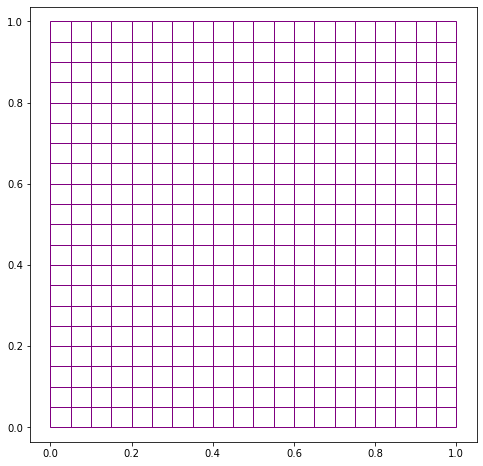

In [40]:
PlotMeshb(xy,eNodes,nE)

## 2.3. Calculate stiffness matrix

In [46]:
K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h)
K.shape

(882, 882)

## 2.4 Boundary condition

In [49]:
fixP = np.argwhere(xy[:,0]<=tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof

array([  0,  41,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79, 441, 482, 502, 503, 504,
       505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517,
       518, 519, 520], dtype=int64)

## 2.5 Loading

In [52]:
dfx = 1e8
dx = 1/20
dy = 1/20

force = np.zeros((nDof,1))
loadP1 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=Ly-tol))
loadP2 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]<=tol))
loadP3 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=tol) & (xy[:,1]<=Ly-tol))
force[loadP1,0] = dfx*dy/2
force[loadP2,0] = dfx*dy/2
force[loadP3,0] = dfx*dy

## 2.6. Solve EOM: K*U=F

In [53]:
disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

In [57]:
pd.DataFrame(dispu).to_csv('dispu.csv')
pd.DataFrame(dispv).to_csv('dispv.csv')

## 2.7. Postprocessing

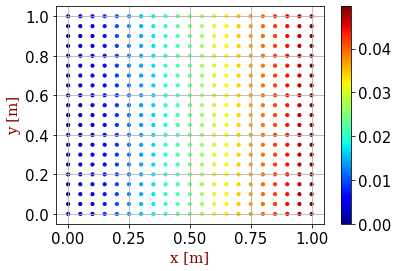

In [58]:
## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xy[:,0], xy[:,1], s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

plt.savefig('dispU', bbox_inches='tight', dpi=300)

In [60]:
max(dispu)

0.049619104807831584

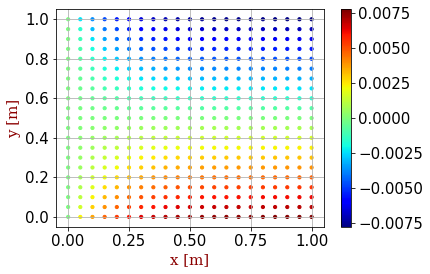

In [59]:
## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xy[:,0], xy[:,1], s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

plt.savefig('dispV', bbox_inches='tight', dpi=300)

In [61]:
max(dispv)

0.0077674078045010505

In [62]:
min(dispv)

-0.00776740702019372